In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import csv
import datetime
import random
from operator import sub

import xgboost as xgb
from sklearn import preprocessing, ensemble
import os


In [2]:
path = "./santander-product-recommendation/"
# df= pd.read_csv( path + "train_ver2.csv", dtype={"sexo":str, "ind_nuevo":str, 
#                                                   "ult_fec_cli_1t":str, 
#                                                   "indext":str})
# df.columns
# df.shape

In [3]:
limit_rows   = 7000000
df           = pd.read_csv(path + "train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str}, nrows=limit_rows)
unique_ids   = pd.Series(df["ncodpers"].unique())
limit_people = 12000
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.ncodpers.isin(unique_id)]
df.describe()

/var/folders/vg/83f50g8n6m16fkcbjq2qsv8c0000gn/T/ipykernel_69004/3495384242.py:2: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df           = pd.read_csv(path + "train_ver2.csv",dtype={"sexo":str,


,ncodpers,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,9.235700e+04,91880.000000,91880.0,91405.000000,91880.000000,7.585100e+04,92357.000000,92357.0,92357.000000,92357.000000,...,92357.000000,92357.000000,92357.000000,92357.000000,92357.000000,92357.000000,92357.000000,92106.000000,92106.000000,92357.000000
mean,8.084625e+05,1.134393,1.0,26.480039,0.486493,1.321288e+05,0.000206,0.0,0.691837,0.000801,...,0.006713,0.010925,0.002772,0.056574,0.052026,0.026636,0.004234,0.064578,0.069702,0.144656
std,4.237270e+05,3.626647,0.0,12.643400,0.499820,2.009152e+05,0.014342,0.0,0.461737,0.028295,...,0.081658,0.103951,0.052576,0.231028,0.222081,0.161017,0.064928,0.245781,0.254646,0.351756
min,1.590300e+04,1.000000,1.0,1.000000,0.000000,1.080000e+04,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.212060e+05,1.000000,1.0,15.000000,0.000000,6.893358e+04,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.257650e+05,1.000000,1.0,28.000000,0.000000,1.007477e+05,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.175478e+06,1.000000,1.0,33.000000,1.000000,1.550705e+05,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.495482e+06,99.000000,1.0,52.000000,1.000000,1.068603e+07,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df["fecha_dato"] = pd.to_datetime(df["fecha_dato"],format="%Y-%m-%d")
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"],format="%Y-%m-%d")
df["fecha_dato"].unique()
df["month"] = pd.DatetimeIndex(df["fecha_dato"]).month
df["age"]   = pd.to_numeric(df["age"], errors="coerce")

In [5]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                       True
fecha_alta                True
ind_nuevo                 True
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp

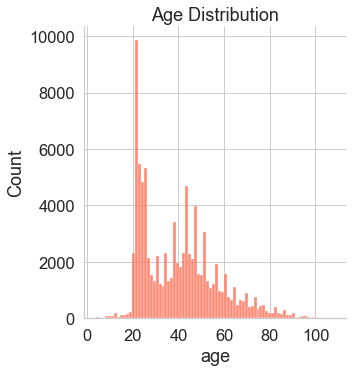

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.displot(df["age"].dropna(), bins=80, kde=False, color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count")

In [7]:
df.loc[df.age < 18,"age"]  = df.loc[(df.age >= 18) & (df.age <= 30),"age"].mean(skipna=True)
df.loc[df.age > 100,"age"] = df.loc[(df.age >= 30) & (df.age <= 100),"age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(),inplace=True)
# df["age"]                  = df["age"].astype(int)

In [8]:
df["ind_nuevo"].isnull().sum()

477

In [9]:
months_active = df.loc[df["ind_nuevo"].isnull(),:].groupby("ncodpers", sort=False).size()

months_active.max()
df.loc[df["ind_nuevo"].isnull(),"ind_nuevo"] = 1

In [10]:
df.antiguedad = pd.to_numeric(df.antiguedad,errors="coerce")
np.sum(df["antiguedad"].isnull())
df.loc[df["antiguedad"].isnull(),"ind_nuevo"].describe()
df.loc[df.antiguedad.isnull(),"antiguedad"] = df.antiguedad.min()
df.loc[df.antiguedad <0, "antiguedad"]      = 0

In [11]:
dates=df.loc[:,"fecha_alta"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
df.loc[df.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
df["fecha_alta"].describe()

/var/folders/vg/83f50g8n6m16fkcbjq2qsv8c0000gn/T/ipykernel_69004/2315345602.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["fecha_alta"].describe()


count                   92357
unique                   3937
top       2011-08-26 00:00:00
freq                      504
first     1995-01-16 00:00:00
last      2015-10-30 00:00:00
Name: fecha_alta, dtype: object

In [12]:
pd.Series([i for i in df.indrel]).value_counts()

1.0     91754
99.0      126
dtype: int64

In [13]:
np.sum(df["ind_actividad_cliente"].isnull())

477

In [14]:
df.drop(["tipodom","cod_prov"],axis=1,inplace=True)

In [15]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme

In [16]:
df.loc[df.ind_actividad_cliente.isnull(),"ind_actividad_cliente"] = \
df["ind_actividad_cliente"].median()

In [17]:
df.nomprov.unique()
df.loc[df.nomprov=="CORU\xc3\x91A, A","nomprov"] = "CORUNA, A"
df.loc[df.nomprov.isnull(),"nomprov"] = "UNKNOWN"

In [72]:
# # df.loc[df.renta.notnull(),:].groupby("nomprov").agg([{"Sum":sum},{"Mean":mean}])
# incomes = df.loc[df.renta.notnull(),:].groupby("nomprov").agg(renta = {"MedianIncome": np.median}).reset_index()['MedianIncome']
# incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
# incomes.reset_index(inplace=True)
# incomes.nomprov = incomes.nomprov.astype("category", categories=[i for i in df.nomprov.unique()],ordered=False)
# incomes.head()
# with sns.axes_style({
#         "axes.facecolor":   "#ffc400",
#         "axes.grid"     :    False,
#         "figure.facecolor": "#c60b1e"}):
#     h = sns.factorplot(data=incomes,
#                    x="nomprov",
#                    y=("renta","MedianIncome"),
#                    order=(i for i in incomes.nomprov),
#                    size=6,
#                    aspect=1.5,
#                    scale=1.0,
#                    color="#c60b1e",
#                    linestyles="None")
# plt.xticks(rotation=90)
# plt.tick_params(labelsize=16,labelcolor="#ffc400")#
# plt.ylabel("Median Income",size=32,color="#ffc400")
# plt.xlabel("City",size=32,color="#ffc400")
# plt.title("Income Distribution by City",size=40,color="#ffc400")
# plt.ylim(0,180000)
# plt.yticks(range(0,180000,40000))

In [18]:
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()

/Users/shallylai/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shallylai/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shallylai/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shallylai/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shallylai/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [19]:
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()
new_incomes

,index,nomprov,renta
0,90253,ALAVA,NaN
1,90216,ALAVA,NaN
2,90218,ALAVA,NaN
3,90219,ALAVA,NaN
4,90220,ALAVA,NaN
...,...,...,...
92352,44476,ZARAGOZA,101250.66
92353,44477,ZARAGOZA,101250.66
92354,44478,ZARAGOZA,101250.66
92355,44485,ZARAGOZA,101250.66


In [20]:
df.ind_nomina_ult1.isnull().sum()

251

In [21]:
df.loc[df.ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
df.loc[df.ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0

In [22]:
string_data = df.select_dtypes(include=["object"])
missing_columns = [col for col in string_data if string_data[col].isnull().any()]
for col in missing_columns:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

Unique values for ind_empleado:
['N' 'A' 'F' 'B' nan]

Unique values for pais_residencia:
['ES' nan 'RO' 'GB' 'CO' 'HR' 'SV' 'PT' 'US' 'DE' 'FR' 'BO' 'CH' 'VE' 'RU'
 'BR' 'BE' 'IT' 'CU' 'ZA' 'AR' 'PE' 'EC']

Unique values for sexo:
['V' 'H' nan]

Unique values for ult_fec_cli_1t:
[nan '2015-09-01' '2015-10-20' '2015-10-26' '2015-10-27' '2015-08-19'
 '2015-07-07' '2015-07-21' '2015-07-14' '2015-08-10' '2015-08-04'
 '2015-08-05' '2015-10-05' '2015-10-15' '2015-09-02' '2015-10-14'
 '2015-08-24' '2015-09-14' '2015-08-17' '2015-10-09' '2015-09-23'
 '2015-07-27' '2015-09-29' '2015-09-10' '2015-10-28' '2015-07-17'
 '2015-09-28' '2015-10-22' '2015-07-01' '2015-08-14' '2015-10-23'
 '2015-07-29' '2015-08-12' '2015-07-22' '2015-10-21' '2015-08-13'
 '2015-10-16' '2015-10-06' '2015-07-03' '2015-08-28' '2015-09-08'
 '2015-09-04' '2015-10-07' '2015-08-25' '2015-09-25' '2015-10-19'
 '2015-09-07' '2015-07-06' '2015-07-09' '2015-09-03' '2015-07-13']

Unique values for indrel_1mes:
['1' 1.0 '1.0' nan '3.

In [23]:
df.loc[df.indfall.isnull(),"indfall"] = "N"
df.loc[df.tiprel_1mes.isnull(),"tiprel_1mes"] = "A"
df.tiprel_1mes = df.tiprel_1mes.astype("category")

# As suggested by @StephenSmith
map_dict = { 1.0  : "1",
            "1.0" : "1",
            "1"   : "1",
            "3.0" : "3",
            "P"   : "P",
            3.0   : "3",
            2.0   : "2",
            "3"   : "3",
            "2.0" : "2",
            "4.0" : "4",
            "4"   : "4",
            "2"   : "2"}

df.indrel_1mes.fillna("P",inplace=True)
df.indrel_1mes = df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
df.indrel_1mes = df.indrel_1mes.astype("category")


unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
for col in unknown_cols:
    df.loc[df[col].isnull(),col] = "UNKNOWN"

In [27]:
from matplotlib import pylab
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

unique_months = pd.DataFrame(pd.Series(df.fecha_dato.unique()).sort_values()).reset_index(drop=True)
unique_months["month_id"] = pd.Series(range(1,1+unique_months.size)) # start with month 1, not 0 to match what we already have
unique_months["month_next_id"] = 1 + unique_months["month_id"]
unique_months.rename(columns={0:"fecha_dato"},inplace=True)
df = pd.merge(df,unique_months,on="fecha_dato")

def status_change(x):
    diffs = x.diff().fillna(0)# first occurrence will be considered Maintained, 
    #which is a little lazy. A better way would be to check if 
    #the earliest date was the same as the earliest we have in the dataset
    #and consider those separately. Entries with earliest dates later than that have 
    #joined and should be labeled as "Added"
    label = ["Added" if i==1 \
         else "Dropped" if i==-1 \
         else "Maintained" for i in diffs]
    return label




/var/folders/vg/83f50g8n6m16fkcbjq2qsv8c0000gn/T/ipykernel_69004/2417141188.py:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'month_next_id_x', 'month_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df,unique_months,on="fecha_dato")


In [30]:
from pylab import *
df.loc[:, feature_cols] = df.loc[:, [i for i in feature_cols]+["ncodpers"]].groupby("ncodpers").transform(status_change)

df = pd.melt(df, id_vars   = [col for col in df.columns if col not in feature_cols],
            value_vars= [col for col in feature_cols])
df = df.loc[df.value!="Maintained",:]
df.shape

# # For thumbnail
# pylab.rcParams['figure.figsize'] = (6, 4)
# with sns.axes_style({
#         "axes.facecolor":   "#ffc400",
#         "axes.grid"     :    False,
#         "figure.facecolor": "#c60b1e"}):
#     h = sns.factorplot(data=incomes,
#                    x="nomprov",
#                    y=("renta","MedianIncome"),
#                    order=(i for i in incomes.nomprov),
#                    size=6,
#                    aspect=1.5,
#                    scale=0.75,
#                    color="#c60b1e",
#                    linestyles="None")
# plt.xticks(rotation=90)
# plt.tick_params(labelsize=12,labelcolor="#ffc400")#
# plt.ylabel("Median Income",size=32,color="#ffc400")
# plt.xlabel("City",size=32,color="#ffc400")
# plt.title("Income Distribution by City",size=40,color="#ffc400")
# plt.ylim(0,180000)
# plt.yticks(range(0,180000,40000))

ValueError: No objects to concatenate